In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym

In [ ]:
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [ ]:
gpu = tf.config.experimental.list_physical_devices('GPU')
for x in gpu:
  tf.config.experimental.set_memory_growth(x)

In [ ]:
dta = '/content/drive/MyDrive/sample_data'
df  = ke.utils.image_dataset_from_directory(dta)
df.map(lambda x, y : (x/255, y))

Found 100 files belonging to 4 classes.


<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

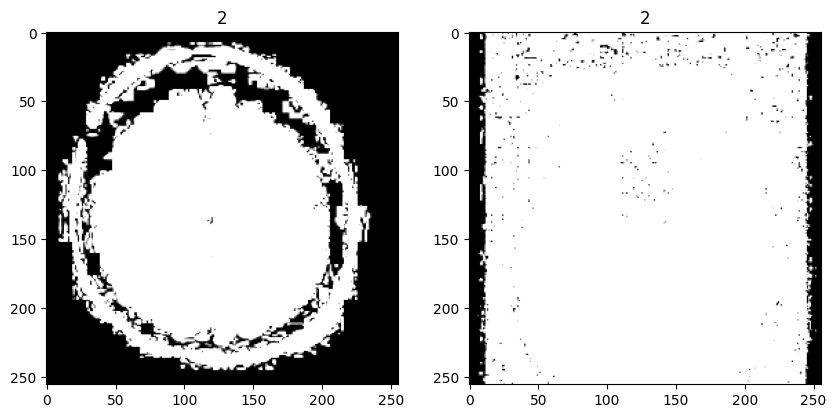

In [ ]:
batch = df.as_numpy_iterator().next()

fig, ax=plt.subplots(ncols=2, figsize=(10,10))
for idx, img in enumerate(batch[0][:2]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
model = ke.models.Sequential([
    ke.layers.Conv2D(input_shape=(256, 256, 3), activation = 'relu', filters= 32, kernel_size=(10,10), kernel_initializer='glorot_uniform'),
    ke.layers.MaxPool2D(pool_size=(2,2)),
    ke.layers.Conv2D(activation='relu', filters = 64, kernel_size=(9,9)),
    ke.layers.MaxPool2D(pool_size=(2,2)),
    ke.layers.Dense(100, activation = 'relu'),
   # ke.layers.Dense(50, activation = 'relu'),
   # ke.layers.Dense(25, activation= 'relu'),
    #ke.layers.Dense(10, activation='relu'),
   ke.layers.Dense(57, activation='relu'),

    ke.layers.Dense(1, activation = 'softmax')])

In [ ]:
model.compile(optimizer='SGD',
              loss = ke.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src2 = self.self_attn(src, src, src, mask=src_mask)[0]
        src = src + self.dropout(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for i in range(num_layers)])
        self.norm = norm

    def forward(self, src, mask=None):
        output = src
        for i in range(len(self.layers)):
            output = self.layers[i](output, mask)
        if self.norm is not None:
            output = self.norm(output)
        return output

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.pos_embedding = PositionalEncoding(d_model)
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout), num_layers)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        patch_dim = C * (self.patch_size ** 2)
        num_patches = (H // self.patch_size) * (W // self.patch_size)
        x = x.view(B, num_patches, patch_dim)
        x = x.permute(1, 0, 2)
        x = self.pos_embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.head(x)
        return x



In [ ]:
class ViTCNN(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, depth, num_heads, mlp_ratio, qkv_bias=False, drop_path_rate=0., layer_norm_eps=1e-5):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio

        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.drop_path = nn.Dropout(p=drop_path_rate)
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop_path_rate=drop_path_rate,
                layer_norm_eps=layer_norm_eps
            )
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim, eps=layer_norm_eps)


        self.cnn_layers = nn.Sequential(
            nn.Conv2d(embed_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.head = nn.Linear(embed_dim + 128 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat([self.cls_token.expand(x.shape[0], -1, -1), x], dim=1)
        x += self.pos_embed

        for block in self.blocks:
            x = block(x)
        x = self.norm(x)


        x_cnn = x[:, 1:].transpose(1, 2).reshape(x.shape[0], self.embed_dim, self.image_size[1] // self.patch_size[1], self.image_size[0] // self.patch_size[0])
        x_cnn = self.cnn_layers(x_cnn)
        x_cnn = x_cnn.flatten(1)

        x = torch.cat([x[:, 0], x_cnn], dim=1)
        x = self.head(x)

        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio, qkv_bias=False, drop_path_rate=0., layer_norm_eps=1e-5):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, qkv_bias=qkv_bias)
        self.drop_path = nn.Dropout(p=drop_path_rate)
        self.norm2 = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(p=drop_path_rate),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [ ]:
class QNetwork(model):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.qnetwork = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32)
            q_values = self.qnetwork(state)
            return torch.argmax(q_values).item()

    def learn(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        q_values = self.qnetwork(state)
        next_q_values = self.qnetwork(next_state)
        q_value = q_values[action]
        next_q_value = torch.max(next_q_values)

        target = reward + self.gamma * next_q_value * (1 - int(done))
        loss = nn.MSELoss()(q_value, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


env = gym.make('CartPole-v1')

agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        score += reward

    print(f'Episode: {episode+1}, Score: {score}')

ValueError: Argument `name` must be a string and cannot contain character `/`. Received: name={'__module__': '__main__', '__qualname__': 'QNetwork', '__init__': <function QNetwork.__init__ at 0x789218993d90>, 'forward': <function QNetwork.forward at 0x789218993e20>, '__classcell__': <cell at 0x78921898db40: empty>} (of type <class 'dict'>)